In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten ,Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from sklearn.model_selection import train_test_split
import timeit
from keras.optimizers import Adam, SGD


import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline# This Python 3 environment comes with many helpful analytics libraries installed


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Using TensorFlow backend.
UsageError: unrecognized arguments: This Python 3 environment comes with many helpful analytics libraries installed


# Loading Data--


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

train_data = pd.read_csv("../input/ece657a-w20-asg3-part2/train.csv")
test_data = pd.read_csv("../input/ece657a-w20-asg3-part2/testX.csv")

x = train_data.iloc[:,2:].values
y = train_data.iloc[:,1].values

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [3]:
test_data

,Id,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,9996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,9997,0,0,0,0,0,0,0,1,0,...,169,131,0,0,0,0,0,0,0,0
9998,9998,0,0,0,1,0,0,0,0,24,...,85,104,138,51,0,3,0,0,0,0


In [4]:
x.shape

(60000, 784)

In [5]:
y

array([4, 0, 0, ..., 4, 0, 2])

# Splitting Data--

In [6]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [7]:
x_train.shape

(48000, 784)

In [8]:
x_test.shape

(12000, 784)

In [9]:
y_train.shape

(48000,)

In [10]:
y_test.shape


(12000,)

In [11]:
x_train.shape, x_test.shape, y_train.shape,y_test.shape

((48000, 784), (12000, 784), (48000,), (12000,))

In [12]:
img_size=28

# 1. Reshaping Data into 28*28
# 2. Normalizing Data

In [13]:
x_train = x_train.reshape(x_train.shape[0],img_size,img_size,1)
x_test = x_test.reshape(x_test.shape[0],img_size,img_size,1)
input_size = (img_size, img_size,1)

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (48000, 28, 28, 1)
x_test shape: (12000, 28, 28, 1)
48000 train samples
12000 test samples
y_train shape: (48000,)


In [14]:
x_train.shape, y_train.shape,x_test.shape,y_test.shape

((48000, 28, 28, 1), (48000,), (12000, 28, 28, 1), (12000,))

In [15]:
img_size = 28
num_classes = 5

# Categorical Labels--

In [16]:
#Converting labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)

In [17]:
y_train.shape

(48000, 5)

In [18]:
y_test.shape

(12000, 5)

# MODEL 1 -- > max_pool=False | batch_size=64 | 
# RESULT-- > val data--> 0.8656 | val loss -->0.5257


In [21]:
#Defining constants
epochs = 50
batch_size = 64
data_augmentation = False
img_size = 28
num_classes = 5

num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3

for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Dropout(0.25)(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)
        x = Dropout(0.25)(x)


    num_filters = 2 * num_filters

x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 14, 14, 64)   3200        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 14, 14, 64)   256         conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 14, 14, 64)   0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

# Saving the model--

In [22]:
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)

/kaggle/working/saved_model/fmnist.h5


# fitting the model--

In [23]:
start=timeit.default_timer()
a=model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test),shuffle=False,
                verbose=1)
stop=timeit.default_timer()

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 48s 1ms/step - loss: 1.8122 - accuracy: 0.6487 - val_loss: 2.2131 - val_accuracy: 0.4993
Epoch 2/50
48000/48000 [==============================] - 36s 747us/step - loss: 1.2650 - accuracy: 0.7656 - val_loss: 1.2236 - val_accuracy: 0.7176
Epoch 3/50
48000/48000 [==============================] - 36s 755us/step - loss: 1.0279 - accuracy: 0.7901 - val_loss: 0.9208 - val_accuracy: 0.8062
Epoch 4/50
48000/48000 [==============================] - 36s 753us/step - loss: 0.8865 - accuracy: 0.8027 - val_loss: 0.7839 - val_accuracy: 0.8378
Epoch 5/50
48000/48000 [==============================] - 35s 739us/step - loss: 0.8014 - accuracy: 0.8122 - val_loss: 0.8890 - val_accuracy: 0.7477
Epoch 6/50
48000/48000 [==============================] - 36s 754us/step - loss: 0.7455 - accuracy: 0.8187 - val_loss: 1.0447 - val_accuracy: 0.6910
Epoch 7/50
48000/48000 [==============================] - 

# Time Taken 1824.5438640850007

In [25]:
time_model1=stop-start
print('Time Taken',time_model1)

Time Taken 1824.5438640850007


# PLOTS--

In [26]:
a.history

{'val_loss': [2.2130789410273235,
  1.2235685876210531,
  0.920834785938263,
  0.7838999811808268,
  0.8890359522501627,
  1.0447362011273702,
  0.7420621960957845,
  0.7369659967422485,
  0.7391466143925984,
  0.6571347610155741,
  0.596442630926768,
  0.6583553857803345,
  0.5859476662476858,
  0.5822828610738119,
  0.5381615511576334,
  0.5386851936976115,
  0.5796381951967875,
  0.5229253053665162,
  0.5890845492680867,
  0.5515727291107178,
  0.5373392651875813,
  0.5363098344802857,
  0.5131804688771566,
  0.5830438572565715,
  0.5626604045232138,
  0.534352642218272,
  0.5449902528127034,
  0.5519683610598246,
  0.5664986519813537,
  0.565456961631775,
  0.6039511852264404,
  0.5505018475850423,
  0.5094112826983134,
  0.594742370446523,
  0.4967396388053894,
  0.5183880513509115,
  0.5168010795911153,
  0.5623201379776,
  0.5176713924407959,
  0.48056757187843324,
  0.5257728530565897,
  0.579382337252299,
  0.48724745559692384,
  0.5200943764050802,
  0.48871161341667174,
  0.

In [27]:
print(a.history['accuracy'])
print(a.history['loss'])
print(a.history['val_accuracy'])
print(a.history['val_loss'])

[0.64872915, 0.7655625, 0.7900625, 0.8027292, 0.81222916, 0.8186875, 0.82164586, 0.8276875, 0.8315, 0.8325833, 0.83754164, 0.84054166, 0.8439375, 0.84685415, 0.8498333, 0.85247916, 0.85420835, 0.8561042, 0.8582708, 0.86216664, 0.8636042, 0.8649167, 0.8638333, 0.86866665, 0.8675625, 0.86954165, 0.8714375, 0.870125, 0.8721667, 0.87439585, 0.87052083, 0.8740625, 0.87475, 0.8749167, 0.8762083, 0.8784583, 0.87908334, 0.87927085, 0.88, 0.8803333, 0.88252085, 0.88125, 0.8833125, 0.8819375, 0.8821458, 0.8839167, 0.88427085, 0.88675, 0.88441664, 0.88339585]
[1.8121666630109152, 1.2650452421506246, 1.0279066400527954, 0.8864764085610708, 0.8014166164398193, 0.7454811489582062, 0.7128151843547821, 0.6851044188340505, 0.6690659055312475, 0.651318124294281, 0.6301102087100346, 0.6151086937586466, 0.6063349106709163, 0.5944790232181549, 0.5829840752283733, 0.5664084520339966, 0.5682340835332871, 0.5645159453550974, 0.5524495110909144, 0.5449485940933227, 0.5387603447039923, 0.5316123495896657, 0.535

### Making dataframe

In [28]:
train_acc=a.history['accuracy']
train_loss=a.history['loss']
val_acc=a.history['val_accuracy']
val_loss=a.history['val_loss']

num=len(a.history['accuracy'])
eplist=np.arange(1,num+1,step=1)
eplist=eplist.tolist()

In [29]:
eplist

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

In [30]:
history_df1=pd.DataFrame(eplist,columns = ['Epoch'])
history_df1['train_acc']=pd.DataFrame(train_acc)

In [31]:
history_df1['train_loss']=pd.DataFrame(train_loss)
history_df1['val_acc']=pd.DataFrame(val_acc)
history_df1['val_loss']=pd.DataFrame(val_loss)

In [32]:
history_df1

,Epoch,train_acc,train_loss,val_acc,val_loss
0,1,0.648729,1.812167,0.499333,2.213079
1,2,0.765562,1.265045,0.717583,1.223569
2,3,0.790062,1.027907,0.806250,0.920835
3,4,0.802729,0.886476,0.837750,0.783900
4,5,0.812229,0.801417,0.747750,0.889036
5,6,0.818687,0.745481,0.691000,1.044736
6,7,0.821646,0.712815,0.801333,0.742062
7,8,0.827688,0.685104,0.805417,0.736966
8,9,0.831500,0.669066,0.789167,0.739147
9,10,0.832583,0.651318,0.835917,0.657135


### Epoch vs Train loss

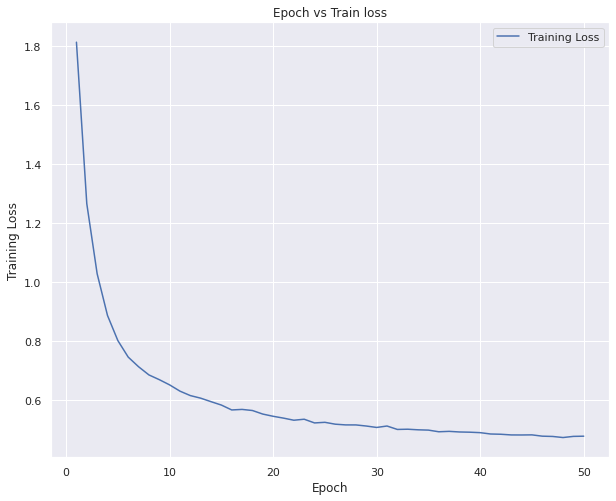

In [33]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='train_loss',data=history_df1)
plt.title("Epoch vs Train loss")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend(["Training Loss"])
plt.show()

### Epoch vs Val loss

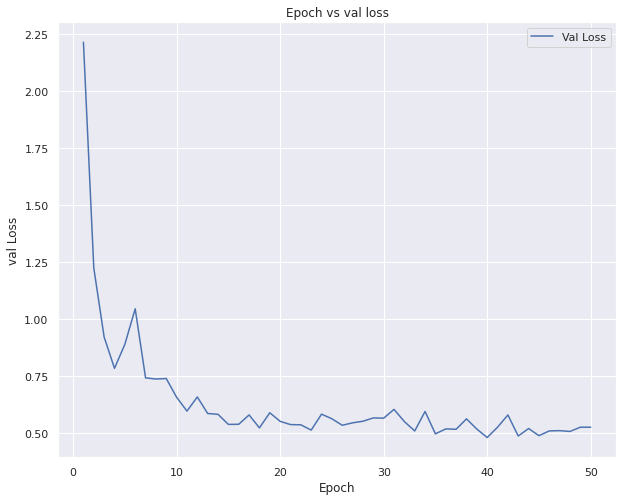

In [34]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='val_loss',data=history_df1)
plt.title("Epoch vs val loss")

plt.xlabel("Epoch")
plt.ylabel("val Loss")
plt.legend(["Val Loss"])
plt.show()

### Epoch vs Train accuracy 

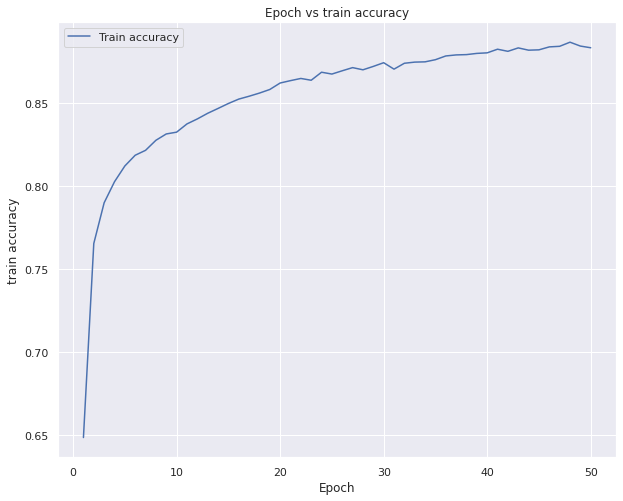

In [35]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='train_acc',data=history_df1)
plt.title("Epoch vs train accuracy")

plt.xlabel("Epoch")
plt.ylabel("train accuracy")
plt.legend(["Train accuracy"])
plt.show()

### Epoch vs Val accuracy

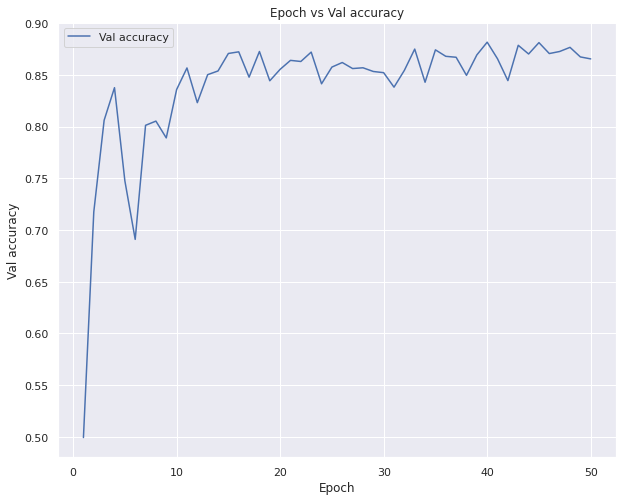

In [36]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='val_acc',data=history_df1)
plt.title("Epoch vs Val accuracy")

plt.xlabel("Epoch")
plt.ylabel("Val accuracy")
plt.legend(["Val accuracy"])
plt.show()

### Train accuracy vs Train loss

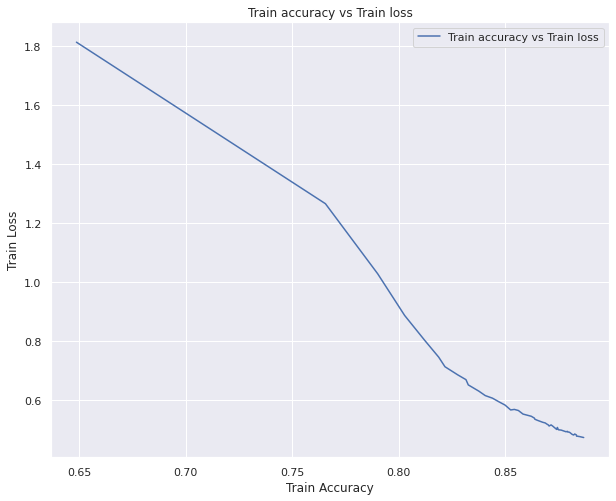

In [37]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='train_acc',y='train_loss',data=history_df1)
plt.title("Train accuracy vs Train loss")

plt.xlabel("Train Accuracy")
plt.ylabel("Train Loss")
plt.legend(["Train accuracy vs Train loss"])
plt.show()

### Val accuracy vs Val loss

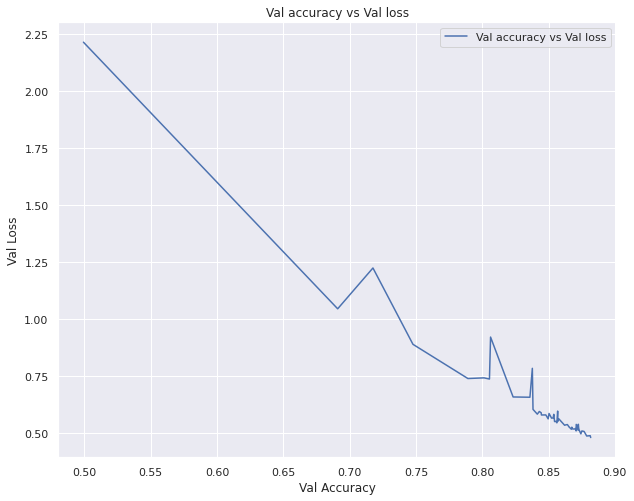

In [38]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='val_acc',y='val_loss',data=history_df1)
plt.title("Val accuracy vs Val loss")

plt.xlabel("Val Accuracy")
plt.ylabel("Val Loss")
plt.legend(["Val accuracy vs Val loss"])
plt.show()

## Unlabelled test data 

In [39]:
test_data

,Id,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,9996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,9997,0,0,0,0,0,0,0,1,0,...,169,131,0,0,0,0,0,0,0,0
9998,9998,0,0,0,1,0,0,0,0,24,...,85,104,138,51,0,3,0,0,0,0


# Reshaping test data--

In [40]:
# for test data

#Storing Pixel array in form length width and channel in df_x_test
df_x_test = test_data.iloc[:,1:].values.reshape(len(test_data),28,28,1)


In [41]:
df_x_test.shape

(10000, 28, 28, 1)

# Normalizing test data--

In [42]:
df_x_test=df_x_test.astype('float32')
#rescaling it between 0 to 1
df_x_test /=255

In [43]:
a

In [44]:
target_classes = model.predict(df_x_test,verbose=1)

10000/10000 [==============================] - 3s 334us/step


In [45]:
target_classes

array([[2.1085194e-04, 7.4238009e-03, 5.5256411e-02, 7.1178931e-01,
        2.2531961e-01],
       [2.7924669e-08, 1.0797018e-05, 5.4989988e-03, 7.9898581e-02,
        9.1459161e-01],
       [8.4772813e-01, 1.4482246e-01, 7.2678500e-03, 1.1442992e-04,
        6.7062465e-05],
       ...,
       [2.4916667e-06, 4.1108672e-03, 1.3392126e-02, 9.6853894e-01,
        1.3955655e-02],
       [1.0953021e-02, 1.5202427e-01, 8.2893562e-01, 7.0834621e-03,
        1.0035761e-03],
       [3.7130940e-07, 2.7195064e-04, 7.7510297e-01, 2.2428583e-01,
        3.3884658e-04]], dtype=float32)

In [46]:
target_classes=np.argmax(target_classes,axis=1)

In [47]:
target_classes

array([3, 4, 0, ..., 3, 2, 2])

In [48]:
target_classes=pd.DataFrame(target_classes)

In [49]:
target_classes

,0
0,3
1,4
2,0
3,1
4,1
...,...
9995,1
9996,1
9997,3
9998,2


In [50]:
target_classes=pd.DataFrame.reset_index(target_classes)
target_classes.columns=['Id','Label']

In [51]:
target_classes

,Id,Label
0,0,3
1,1,4
2,2,0
3,3,1
4,4,1
...,...,...
9995,9995,1
9996,9996,1
9997,9997,3
9998,9998,2


In [52]:
filename = 'submission_resnet.csv'
target_classes.to_csv(filename,index=False)
print('Saved file:' + filename)

Saved file:submission_resnet.csv


# MODEL2 ::->with maxpool=True and batch size small=32 | val_accuracy = 0.8487 | val loss 0.5429

In [60]:
#Defining constants
epochs = 50
batch_size = 32
data_augmentation = False
img_size = 28

num_classes = 5
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = True



#Creating model based on ResNet published archietecture
inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Dropout(0.25)(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)
        x = Dropout(0.25)(x)


    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model1 = Model(inputs=inputs, outputs=outputs)
model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model1.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 14, 14, 64)   3200        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 14, 14, 64)   256         conv2d_71[0][0]                  
__________________________________________________________________________________________________
activation_61 (Activation)      (None, 14, 14, 64)   0           batch_normalization_61[0][0]     
____________________________________________________________________________________________

# Saving the model --

In [61]:
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_resnet_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)

/kaggle/working/saved_model/fmnist_resnet_model.h5


# Fitting the model--

In [62]:
start=timeit.default_timer()

b=model1.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test),shuffle=False)
stop=timeit.default_timer()

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 50s 1ms/step - loss: 1.2540 - accuracy: 0.6682 - val_loss: 0.8899 - val_accuracy: 0.7944
Epoch 2/50
48000/48000 [==============================] - 46s 953us/step - loss: 0.8945 - accuracy: 0.7674 - val_loss: 0.8194 - val_accuracy: 0.7653
Epoch 3/50
48000/48000 [==============================] - 47s 971us/step - loss: 0.7637 - accuracy: 0.7920 - val_loss: 0.6419 - val_accuracy: 0.8462
Epoch 4/50
48000/48000 [==============================] - 45s 945us/step - loss: 0.6973 - accuracy: 0.8041 - val_loss: 0.6149 - val_accuracy: 0.8376
Epoch 5/50
48000/48000 [==============================] - 45s 940us/step - loss: 0.6569 - accuracy: 0.8135 - val_loss: 0.6777 - val_accuracy: 0.8093
Epoch 6/50
48000/48000 [==============================] - 46s 957us/step - loss: 0.6289 - accuracy: 0.8209 - val_loss: 0.6143 - val_accuracy: 0.8223
Epoch 7/50
48000/48000 [==============================] - 

In [63]:
time_model2=stop-start
print('Time Taken',time_model2)

Time Taken 2306.2938370890006


# Time Taken 2306.2938370890006

# PLOTS--

In [64]:
b.history

{'val_loss': [0.8899484082857768,
  0.819418796380361,
  0.6418641999562581,
  0.6148698457876841,
  0.6776525935331981,
  0.6142743357817332,
  0.6003492039044698,
  0.5508305443922679,
  0.5663455169200897,
  0.6128928836981455,
  0.5871529846986134,
  0.49659633620580035,
  0.6051468351682027,
  0.5242192482948304,
  0.5729184614817301,
  0.6128149540424347,
  0.5441467655499777,
  0.5827109336853027,
  0.7360397005081176,
  0.5437418049176534,
  0.5570863404273987,
  0.4999017593463262,
  0.6147236778736115,
  0.5559826489686966,
  0.48982639630635577,
  0.5625834793249767,
  0.4945476682186127,
  0.5309499529997508,
  0.5205478433767955,
  0.5353192473649979,
  0.546241291364034,
  0.5425426930586497,
  0.5475220126310985,
  0.5194001006285349,
  0.5984695660273234,
  0.5227600379784902,
  0.5162194385925929,
  0.49888133200009666,
  0.5296771886348725,
  0.4976915970245997,
  0.5522248465617497,
  0.5491087427536646,
  0.7180474462509155,
  0.588061492005984,
  0.5559942187070847

In [65]:
print(b.history['accuracy'])
print(b.history['loss'])
print(b.history['val_accuracy'])
print(b.history['val_loss'])

[0.66816664, 0.767375, 0.79195833, 0.8041458, 0.81352085, 0.82091665, 0.82752085, 0.832125, 0.837625, 0.83966666, 0.8444375, 0.8493958, 0.8513542, 0.85322917, 0.85541666, 0.85925, 0.8595, 0.8613125, 0.863125, 0.8651875, 0.8656875, 0.8673125, 0.87060416, 0.8684792, 0.8722917, 0.8717292, 0.87266666, 0.87297916, 0.87633336, 0.8746875, 0.8765208, 0.8791875, 0.8787917, 0.8784583, 0.87939584, 0.878375, 0.8811875, 0.8812708, 0.8837917, 0.88158333, 0.8824375, 0.8843542, 0.88297915, 0.88341665, 0.88354164, 0.8857292, 0.8845417, 0.887, 0.8856458, 0.8876875]
[1.2539560331900914, 0.8945159799456597, 0.7637202497919401, 0.6973178897102674, 0.6569391105969747, 0.6289118630091349, 0.605789847612381, 0.5857931958436966, 0.5719017211993536, 0.5572167784571648, 0.5431243153611819, 0.5316725422143936, 0.5230532294313113, 0.5175167057812214, 0.5120422641634941, 0.5055455592075984, 0.4991475220620632, 0.4946829739709695, 0.48855839120348293, 0.4836790230770906, 0.48613629946112635, 0.47902681757013005, 0.4

### Making dataframe

In [66]:
train_acc_1=b.history['accuracy']
train_loss_1=b.history['loss']
val_acc_1=b.history['val_accuracy']
val_loss_1=b.history['val_loss']

num=len(b.history['accuracy'])
eplist=np.arange(1,num+1,step=1)
eplist=eplist.tolist()

In [67]:
eplist

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

In [68]:
history_df2=pd.DataFrame(eplist,columns = ['Epoch'])
history_df2['train_acc']=pd.DataFrame(train_acc_1)

In [69]:
history_df2['train_loss']=pd.DataFrame(train_loss_1)
history_df2['val_acc']=pd.DataFrame(val_acc_1)
history_df2['val_loss']=pd.DataFrame(val_loss_1)

In [70]:
history_df2

,Epoch,train_acc,train_loss,val_acc,val_loss
0,1,0.668167,1.253956,0.794417,0.889948
1,2,0.767375,0.894516,0.765333,0.819419
2,3,0.791958,0.763720,0.846167,0.641864
3,4,0.804146,0.697318,0.837583,0.614870
4,5,0.813521,0.656939,0.809333,0.677653
5,6,0.820917,0.628912,0.822333,0.614274
6,7,0.827521,0.605790,0.831167,0.600349
7,8,0.832125,0.585793,0.846167,0.550831
8,9,0.837625,0.571902,0.839917,0.566346
9,10,0.839667,0.557217,0.810583,0.612893


### Epoch vs Train loss

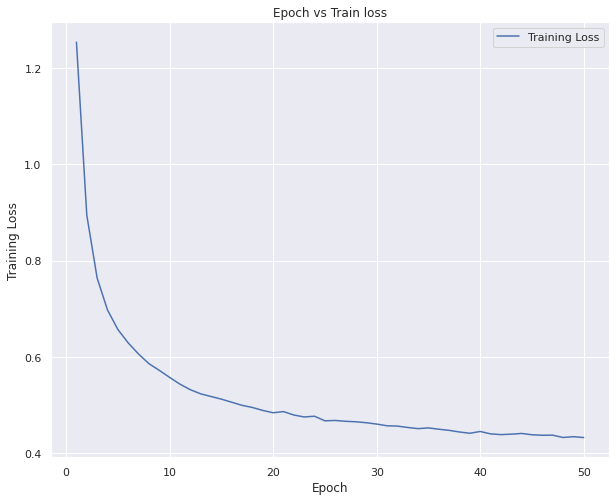

In [71]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='train_loss',data=history_df2)
plt.title("Epoch vs Train loss")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend(["Training Loss"])
plt.show()

### Epoch vs Val loss

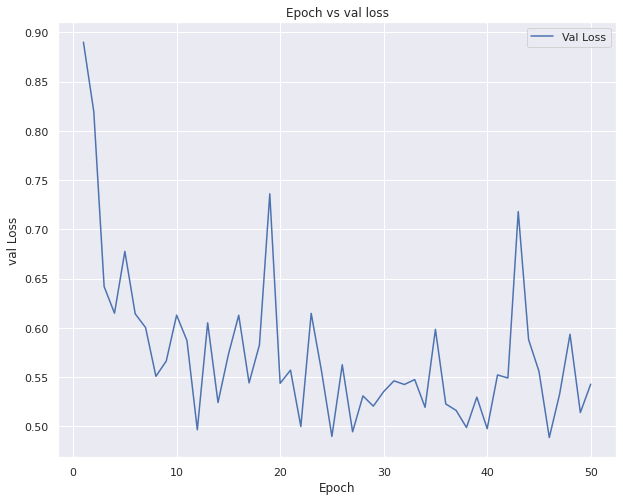

In [72]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='val_loss',data=history_df2)
plt.title("Epoch vs val loss")

plt.xlabel("Epoch")
plt.ylabel("val Loss")
plt.legend(["Val Loss"])
plt.show()

### Epoch vs Train accuracy 

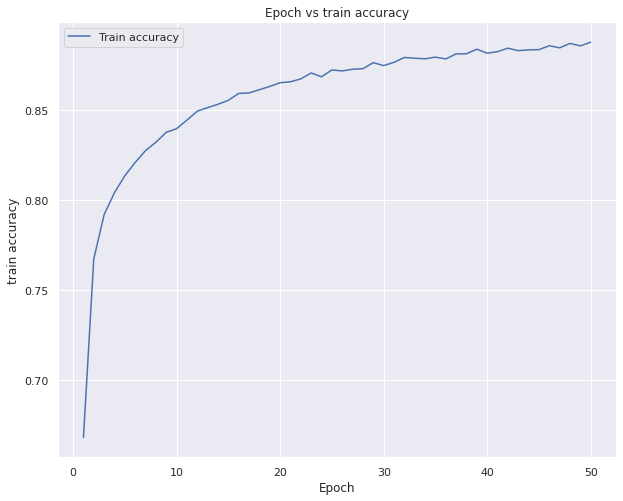

In [73]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='train_acc',data=history_df2)
plt.title("Epoch vs train accuracy")

plt.xlabel("Epoch")
plt.ylabel("train accuracy")
plt.legend(["Train accuracy"])
plt.show()

### Epoch vs Val accuracy

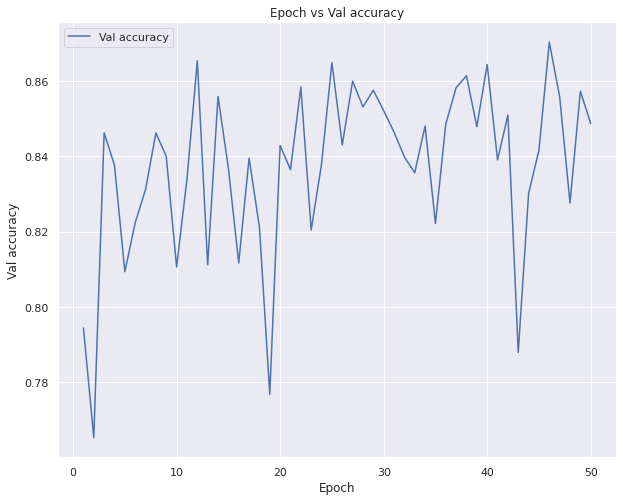

In [74]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='val_acc',data=history_df2)
plt.title("Epoch vs Val accuracy")

plt.xlabel("Epoch")
plt.ylabel("Val accuracy")
plt.legend(["Val accuracy"])
plt.show()

### Train accuracy vs Train loss

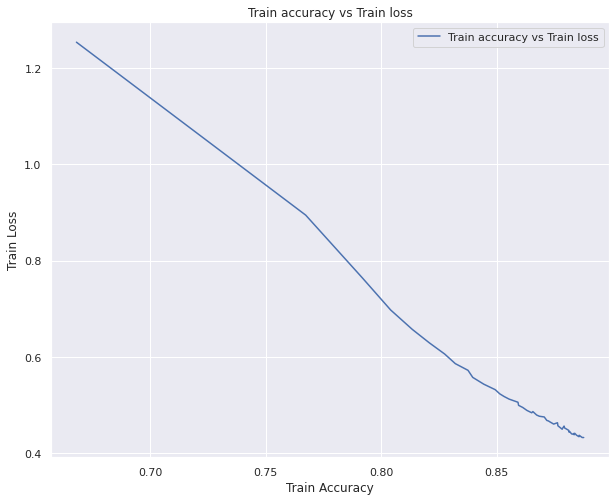

In [75]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='train_acc',y='train_loss',data=history_df2)
plt.title("Train accuracy vs Train loss")

plt.xlabel("Train Accuracy")
plt.ylabel("Train Loss")
plt.legend(["Train accuracy vs Train loss"])
plt.show()

### Val accuracy vs Val loss

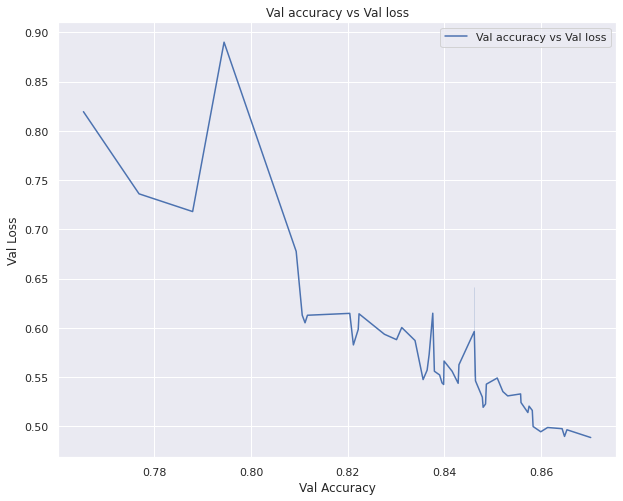

In [76]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='val_acc',y='val_loss',data=history_df2)
plt.title("Val accuracy vs Val loss")

plt.xlabel("Val Accuracy")
plt.ylabel("Val Loss")
plt.legend(["Val accuracy vs Val loss"])
plt.show()

## Unlabelled test data 

In [77]:
test_data

,Id,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,9996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,9997,0,0,0,0,0,0,0,1,0,...,169,131,0,0,0,0,0,0,0,0
9998,9998,0,0,0,1,0,0,0,0,24,...,85,104,138,51,0,3,0,0,0,0


# Reshaping the test data into 28*28

In [78]:
# for test data
#Storing Pixel array in form length width and channel in df_x_test
df_x_test = test_data.iloc[:,1:].values.reshape(len(test_data),28,28,1)


In [79]:
df_x_test.shape

(10000, 28, 28, 1)

In [80]:
df_x_test

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


# Normalizing the test data--

In [81]:
df_x_test=df_x_test.astype('float32')
#rescaling it between 0 to 1
df_x_test /=255


In [82]:
b

In [83]:
target_classes1 = model1.predict(df_x_test,verbose=1)

10000/10000 [==============================] - 2s 210us/step


In [84]:
target_classes1

array([[4.3327014e-05, 1.8351834e-03, 5.2225742e-02, 6.1337757e-01,
        3.3251819e-01],
       [1.7686329e-09, 2.5053687e-08, 6.1387224e-03, 1.9731428e-02,
        9.7412986e-01],
       [7.9645628e-01, 2.0169857e-01, 1.7703814e-03, 2.7513242e-05,
        4.7303361e-05],
       ...,
       [3.6387597e-04, 1.0561769e-02, 5.6215733e-01, 1.5597761e-01,
        2.7093941e-01],
       [8.5292629e-04, 2.9157946e-02, 9.6931267e-01, 6.4366776e-04,
        3.2764834e-05],
       [5.3169488e-06, 3.3343330e-03, 8.1374860e-01, 1.8222347e-01,
        6.8826653e-04]], dtype=float32)

In [85]:
target_classes1=np.argmax(target_classes1,axis=1)

In [86]:
target_classes1

array([3, 4, 0, ..., 2, 2, 2])

In [87]:
target_classes1=pd.DataFrame(target_classes1)

In [88]:
target_classes1

,0
0,3
1,4
2,0
3,1
4,1
...,...
9995,1
9996,1
9997,2
9998,2


In [89]:
target_classes1=pd.DataFrame.reset_index(target_classes1)
target_classes1.columns=['Id','Label']

In [90]:
target_classes1

,Id,Label
0,0,3
1,1,4
2,2,0
3,3,1
4,4,1
...,...,...
9995,9995,1
9996,9996,1
9997,9997,2
9998,9998,2


In [91]:
filename = 'submission_resnet1.csv'
target_classes1.to_csv(filename,index=False)
print('Saved file:' + filename)

Saved file:submission_resnet1.csv


# MODEL 3 --> OPTIMIZER= SGD | max_pool=False | batch_size=64 |val accuracy- 0.5820|  val_loss: 2.1792 |epoch=50

In [96]:
#Defining constants
epochs = 50
batch_size = 64
data_augmentation = False
img_size = 28
num_classes = 5

num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

#Creating model based on ResNet published archietecture
inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Dropout(0.25)(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)
        x = Dropout(0.25)(x)


    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])
model2.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_126 (Conv2D)             (None, 14, 14, 64)   3200        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_108 (BatchN (None, 14, 14, 64)   256         conv2d_126[0][0]                 
__________________________________________________________________________________________________
activation_108 (Activation)     (None, 14, 14, 64)   0           batch_normalization_108[0][0]    
____________________________________________________________________________________________

# Saving the model--

In [97]:
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist3.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)

/kaggle/working/saved_model/fmnist3.h5


# Fitting the model--

In [98]:
start=timeit.default_timer()
c=model2.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test),shuffle=False,verbose=1)
stop=timeit.default_timer()

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 38s 783us/step - loss: 2.4474 - accuracy: 0.4447 - val_loss: 2.7506 - val_accuracy: 0.2752
Epoch 2/50
48000/48000 [==============================] - 31s 645us/step - loss: 1.8791 - accuracy: 0.5962 - val_loss: 2.4982 - val_accuracy: 0.3436
Epoch 3/50
48000/48000 [==============================] - 32s 668us/step - loss: 1.7779 - accuracy: 0.6448 - val_loss: 2.6955 - val_accuracy: 0.3322
Epoch 4/50
48000/48000 [==============================] - 31s 655us/step - loss: 1.7113 - accuracy: 0.6766 - val_loss: 2.8268 - val_accuracy: 0.3372
Epoch 5/50
48000/48000 [==============================] - 32s 666us/step - loss: 1.6708 - accuracy: 0.6930 - val_loss: 2.9528 - val_accuracy: 0.3316
Epoch 6/50
48000/48000 [==============================] - 31s 646us/step - loss: 1.6413 - accuracy: 0.7041 - val_loss: 2.8676 - val_accuracy: 0.3542
Epoch 7/50
48000/48000 [==============================] 

# Time Taken 1596.5268217260018

In [99]:
time_model1=stop-start
print('Time Taken',time_model1)

Time Taken 1596.5268217260018


# PLOTS--

In [100]:
c.history

{'val_loss': [2.750574857711792,
  2.4982003434499105,
  2.695465165456136,
  2.8268222001393637,
  2.95280021349589,
  2.867557725270589,
  2.656511090596517,
  2.9479983310699462,
  2.750271945953369,
  2.879355218887329,
  2.850590705235799,
  2.9407551860809327,
  2.65444976234436,
  2.6475596853892007,
  2.746317502975464,
  2.698453404108683,
  2.705674369812012,
  2.725066577275594,
  2.5207172826131186,
  2.643544225692749,
  2.5046863384246825,
  2.5652092088063556,
  2.6413727906545,
  2.529922835667928,
  2.6496666005452476,
  2.498083915710449,
  2.502498088200887,
  2.3868188858032227,
  2.6107095184326172,
  2.419314807891846,
  2.6178573563893637,
  2.3447084503173827,
  2.3341483942667645,
  2.281260950724284,
  2.3777653001149495,
  2.381961280822754,
  2.245542099634806,
  2.520303584416707,
  2.244874615351359,
  2.271777619679769,
  2.337315394083659,
  2.1495193519592286,
  2.1448322445551553,
  2.188962306022644,
  2.1482169116338095,
  2.14852360757192,
  2.24717

In [101]:
print(c.history['accuracy'])
print(c.history['loss'])
print(c.history['val_accuracy'])
print(c.history['val_loss'])

[0.44470835, 0.59620833, 0.6448333, 0.676625, 0.69297916, 0.7040625, 0.7164583, 0.72583336, 0.73245835, 0.73952085, 0.7476042, 0.75122917, 0.7543125, 0.7604167, 0.761625, 0.767625, 0.775, 0.7751875, 0.779875, 0.7792917, 0.7842708, 0.784875, 0.7897292, 0.79010415, 0.79185414, 0.794375, 0.79575, 0.7984375, 0.801125, 0.80175, 0.8035, 0.80722916, 0.8080417, 0.8078125, 0.8102083, 0.8125, 0.81470835, 0.8143542, 0.8160625, 0.81752086, 0.8201875, 0.81947917, 0.821625, 0.82235414, 0.82775, 0.82383335, 0.8285625, 0.82725, 0.8286667, 0.830375]
[2.447375377813975, 1.8791137498219808, 1.7778969577153523, 1.7112940969467163, 1.6708313577969869, 1.6412725874582927, 1.6144488565127055, 1.5909812995592754, 1.5745553881327312, 1.555149166584015, 1.5367402497927347, 1.5253477589289348, 1.5148731479644775, 1.4993575024604797, 1.489980850537618, 1.4741153047879536, 1.4650153104464214, 1.455033262093862, 1.4448759401639302, 1.4350805598894756, 1.4260491600036622, 1.4181931370099385, 1.4082286305427552, 1.40

### Making dataframe

In [102]:
train_acc=c.history['accuracy']
train_loss=c.history['loss']
val_acc=c.history['val_accuracy']
val_loss=c.history['val_loss']

num=len(c.history['accuracy'])
eplist=np.arange(1,num+1,step=1)
eplist=eplist.tolist()

In [103]:
eplist

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

In [104]:
history_df3=pd.DataFrame(eplist,columns = ['Epoch'])
history_df3['train_acc']=pd.DataFrame(train_acc)

In [105]:
history_df3['train_loss']=pd.DataFrame(train_loss)
history_df3['val_acc']=pd.DataFrame(val_acc)
history_df3['val_loss']=pd.DataFrame(val_loss)

In [106]:
history_df3

,Epoch,train_acc,train_loss,val_acc,val_loss
0,1,0.444708,2.447375,0.275250,2.750575
1,2,0.596208,1.879114,0.343583,2.498200
2,3,0.644833,1.777897,0.332167,2.695465
3,4,0.676625,1.711294,0.337250,2.826822
4,5,0.692979,1.670831,0.331583,2.952800
5,6,0.704063,1.641273,0.354167,2.867558
6,7,0.716458,1.614449,0.391167,2.656511
7,8,0.725833,1.590981,0.358417,2.947998
8,9,0.732458,1.574555,0.389250,2.750272
9,10,0.739521,1.555149,0.379333,2.879355


### Epoch vs Train loss

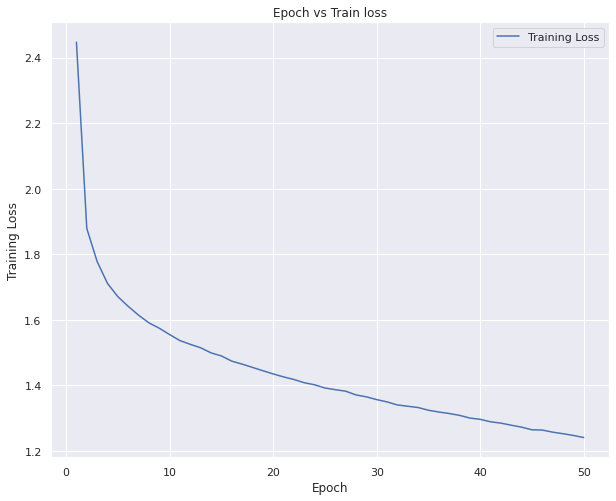

In [107]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='train_loss',data=history_df3)
plt.title("Epoch vs Train loss")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend(["Training Loss"])
plt.show()

### Epoch vs Val loss

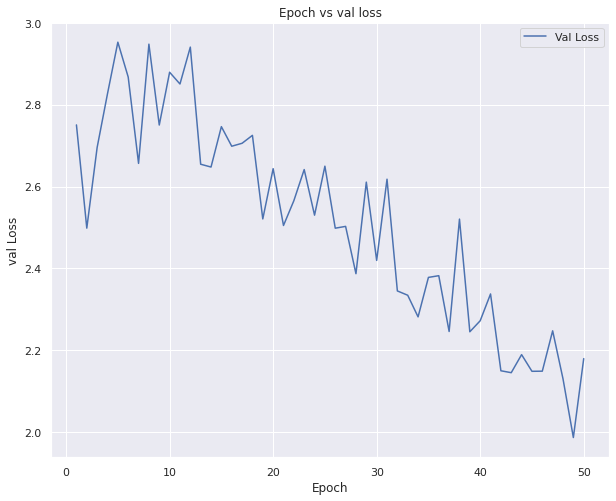

In [108]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='val_loss',data=history_df3)
plt.title("Epoch vs val loss")

plt.xlabel("Epoch")
plt.ylabel("val Loss")
plt.legend(["Val Loss"])
plt.show()

### Epoch vs Train accuracy 

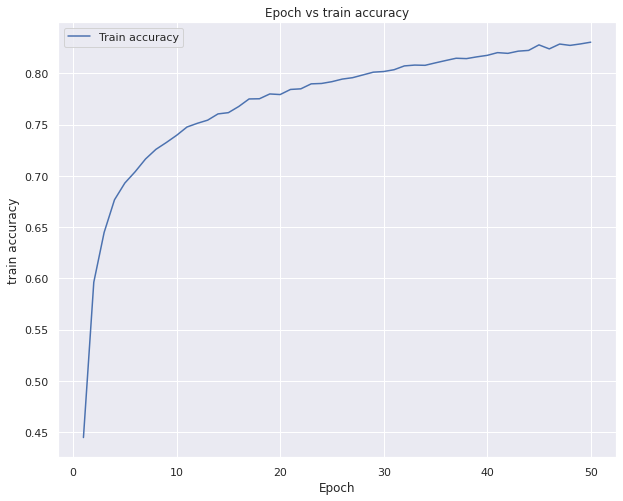

In [109]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='train_acc',data=history_df3)
plt.title("Epoch vs train accuracy")

plt.xlabel("Epoch")
plt.ylabel("train accuracy")
plt.legend(["Train accuracy"])
plt.show()

### Epoch vs Val accuracy

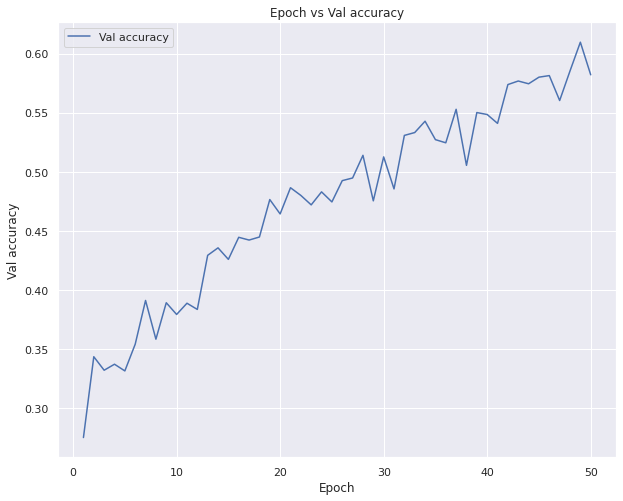

In [110]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='Epoch',y='val_acc',data=history_df3)
plt.title("Epoch vs Val accuracy")

plt.xlabel("Epoch")
plt.ylabel("Val accuracy")
plt.legend(["Val accuracy"])
plt.show()

### Train accuracy vs Train loss

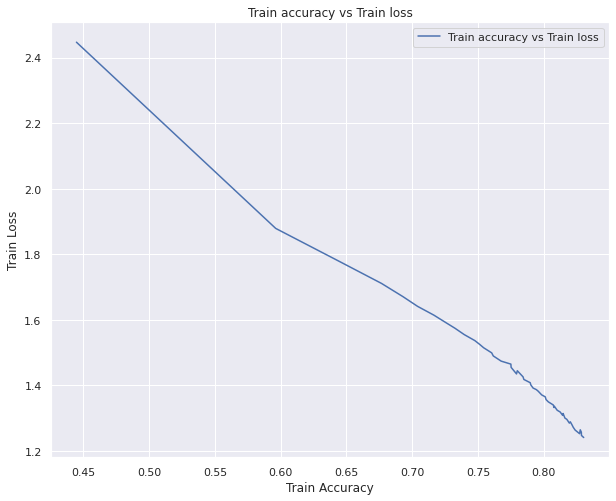

In [111]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='train_acc',y='train_loss',data=history_df3)
plt.title("Train accuracy vs Train loss")

plt.xlabel("Train Accuracy")
plt.ylabel("Train Loss")
plt.legend(["Train accuracy vs Train loss"])
plt.show()

### Val accuracy vs Val loss

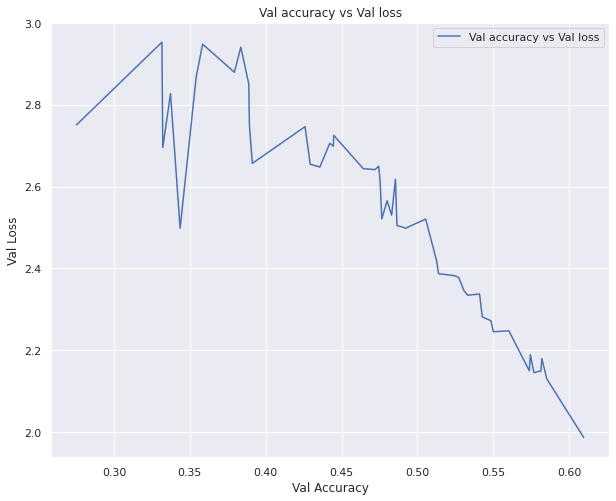

In [112]:
import seaborn as sns;
fig= plt.figure(figsize=(10,8))
sns.set(style="darkgrid")
ax=sns.lineplot(x='val_acc',y='val_loss',data=history_df3)
plt.title("Val accuracy vs Val loss")

plt.xlabel("Val Accuracy")
plt.ylabel("Val Loss")
plt.legend(["Val accuracy vs Val loss"])
plt.show()

## Unlabelled test data 

In [113]:
test_data

,Id,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,9996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,9997,0,0,0,0,0,0,0,1,0,...,169,131,0,0,0,0,0,0,0,0
9998,9998,0,0,0,1,0,0,0,0,24,...,85,104,138,51,0,3,0,0,0,0


# Reshaping the test data

In [114]:
# for test data

#Storing Pixel array in form length width and channel in df_x_test
df_x_test = test_data.iloc[:,1:].values.reshape(len(test_data),28,28,1)


In [115]:
df_x_test.shape

(10000, 28, 28, 1)

# Normalizing the test data--

In [116]:
df_x_test=df_x_test.astype('float32')
#rescaling it between 0 to 1
df_x_test /=255

In [119]:
target_classes = model2.predict(df_x_test,verbose=1)

10000/10000 [==============================] - 3s 329us/step


In [120]:
target_classes

array([[1.17838272e-05, 3.50376815e-02, 8.61353651e-02, 8.77040863e-01,
        1.77438417e-03],
       [1.35118025e-04, 1.94529295e-02, 1.30995482e-01, 6.72060728e-01,
        1.77355781e-01],
       [9.69171405e-01, 2.99857929e-02, 8.21458525e-04, 5.87904697e-06,
        1.55092694e-05],
       ...,
       [7.13959802e-03, 3.10737878e-01, 4.56010967e-01, 2.12710679e-01,
        1.34009253e-02],
       [8.41051266e-02, 5.88573992e-01, 3.24311018e-01, 2.90317368e-03,
        1.06753054e-04],
       [8.96946076e-05, 2.38187481e-02, 9.66197431e-01, 9.85060353e-03,
        4.35805014e-05]], dtype=float32)

In [121]:
target_classes=np.argmax(target_classes,axis=1)

In [122]:
target_classes

array([3, 3, 0, ..., 2, 1, 2])

In [123]:
target_classes=pd.DataFrame(target_classes)

In [124]:
target_classes

,0
0,3
1,3
2,0
3,1
4,1
...,...
9995,1
9996,1
9997,2
9998,1


In [125]:
target_classes=pd.DataFrame.reset_index(target_classes)
target_classes.columns=['Id','Label']

In [126]:
target_classes

,Id,Label
0,0,3
1,1,3
2,2,0
3,3,1
4,4,1
...,...,...
9995,9995,1
9996,9996,1
9997,9997,2
9998,9998,1


In [128]:
filename = 'submission_resnet2.csv'
target_classes.to_csv(filename,index=False)
print('Saved file:' + filename)

Saved file:submission_resnet2.csv
